In [1]:
# All necessary imports for this notebook
# You can see them in the requirements.txt

# for data processing
import math
import pandas as pd
import geohash

# for visualization
import folium
from folium import plugins

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# NOTE: You have to reference the CSV's from the Air Tube data set in 0. Data

# Load Air Tube Data into a Data Frame
# You can also concatenate them
df = pd.DataFrame(pd.read_csv('data_bg_2017.csv'))

In [3]:
# Extract longitude from geohash
def get_lattitude(ghash):
    try:
        return geohash.decode(ghash)[0]
    except ValueError as e:
        print("value: {}, error: {}".format(ghash, e))
        return -1
    except TypeError as e:
        print("value: {}, error: {}".format(ghash, e))
        return -1

# Extract lattitude from geohash
def get_longitude(ghash):
    try:
        return geohash.decode(ghash)[1]
    except ValueError as e:
        print("geohash: {}, error: {}".format(ghash, e))
        return -1
    except TypeError as e:
        print("geohash: {}, error: {}".format(ghash, e))
        return -1

# Assign longitude and lattitude
df['latitude'] = df['geohash'].apply(get_lattitude)
df['longitude'] = df['geohash'].apply(get_longitude)

value: m-2105171, error: geohash code is [0123456789bcdefghjkmnpqrstuvwxyz]+
geohash: m-2105171, error: geohash code is [0123456789bcdefghjkmnpqrstuvwxyz]+


In [4]:
# Remove rows with an invalid geohash

df = df[(df['longitude'] != -1) & (df['latitude'] != -1)]

In [5]:
# Filter data only for Sofia

def distance(x1, x2, y1, y2):
    return math.sqrt((y1 - x1) ** 2 + (y2 - x2) ** 2)

sofia_center = [42.697708, 23.321867]
german_village = [42.609620, 23.410710]
sofia_radius = distance(*sofia_center, *german_village)

df['in_sofia'] = df[['latitude', 'longitude']].apply(
    lambda point: 1 if distance(*point, *sofia_center) < sofia_radius else 0, axis=1
)

# unique_geohashes = df['geohash'].unique()

# Save to CSV
# df[df.in_sofia == 1][['geohash', 'longitude', 'latitude']].to_csv('geohash_mapping_sofia_2017.csv', index=False)

sofia_df = df[df.in_sofia == 1]

sofia_df.head()

,time,geohash,P1,P2,temperature,humidity,pressure,latitude,longitude,in_sofia
0,2017-09-06T20:00:00Z,sx8d5r7wmxr,9,8,14,55,0,42.580,23.351000,1
1,2017-09-06T20:00:00Z,sx8d6zjg5h8,9,8,0,0,0,42.622,23.332000,1
6,2017-09-06T20:00:00Z,sx8dem6pp1h,15,11,14,54,94841,42.657,23.349000,1
9,2017-09-06T20:00:00Z,sx8devjgkk2,14,13,18,10,0,42.655,23.375999,1
12,2017-09-06T20:00:00Z,sx8d9g29ns5,0,0,17,55,93535,42.645,23.281000,1


In [6]:
sofia_df.describe()

,P1,P2,temperature,humidity,pressure,latitude,longitude,in_sofia
count,419642.000000,419642.000000,419642.000000,419642.000000,419642.000000,419642.000000,419642.000000,419642.0
mean,43.176872,23.397098,8.939606,61.674442,81517.876693,42.678531,23.323406,1.0
std,78.353541,39.862942,12.704712,22.505932,33257.032365,0.029506,0.041544,0.0
min,0.000000,0.000000,-148.000000,0.000000,0.000000,42.580000,23.229000,1.0
25%,10.000000,7.000000,4.000000,50.000000,93982.000000,42.661000,23.291000,1.0
50%,22.000000,13.000000,9.000000,66.000000,94915.000000,42.680000,23.323999,1.0
75%,45.000000,26.000000,14.000000,78.000000,95513.000000,42.694000,23.355000,1.0
max,2000.000000,1000.000000,63.000000,100.000000,162962.000000,42.804000,23.419001,1.0


As we can see from the data summary above, the mean PM10 in Sofia is rather high and very close to the PM10 threshold of 50.

Below is a distribution of the measured PM10 values.

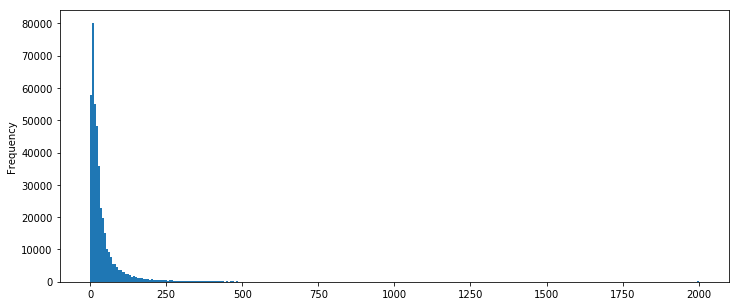

In [7]:
sofia_df.P1.plot.hist(bins=300, figsize=(12, 5))

From the histogram above and the boxplot below we see that there are quite many PM10 values above the allowed threshold of 50.

It would be very helpful to unerstand WHEN and WHERE the PM10 threshold has been surpassed.

At the bottom of this notebook this goal is reached by visualizing a Heat Map of PM10 over Sofia over the course of time.

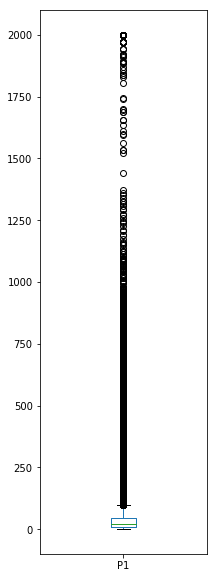

In [8]:
sofia_df.P1.plot.box(figsize=(3, 10))

In [33]:
def make_heatmap(df, timestamp, metric):
    """Create a Heat Map of Sofia for a given timestamp to visualize a given metric.
    For example, to visualize PM10 pollution
    
    The map is interactive.

    The map also visualizes clusters of the locations.

    Keyword arguments:
    df     -- the data frame with time, longitude, lattitude and the chosen metric
    timestamp -- the point in time for which to visualize the heat map
    metric -- the metric, used for visualization
    """
    points = df[df.time == timestamp]
    
    folium_map = folium.Map(location=sofia_center,
                            zoom_start=11,
                            tiles='Stamen Terrain')

    marker_cluster = plugins.MarkerCluster().add_to(folium_map)
    
    for i in range(0, len(points)):
        point = points.iloc[i]

        folium.Marker(
            [point['latitude'], point['longitude']],
            popup=str(point['P1'])
        ).add_to(marker_cluster)
        
#         folium.Circle(
#             radius=10,
#             location=[point['latitude'], point['longitude']],
#             popup=str(point['P1']),
#             color='#333333',
#             fill=False
#         ).add_to(folium_map)

    plugins.MarkerCluster().add_to(folium_map)
        
    # plot heatmap
    folium_map.add_child(plugins.HeatMap(
        points[['latitude', 'longitude', metric]].as_matrix(),
        min_opacity=0.2,
        max_val=points[metric].max(),
        radius=30, blur=17,
        max_zoom=1
    ))

    # You can also save the interactive heat map as an HTML file
    # folium_map.save("output-map.html")
    
    return folium_map

In [34]:
# Visualize the geographic distribution of PM10 in Sofia for a specific point in time.

make_heatmap(sofia_df, '2017-09-06T20:00:00Z', 'P1')

In [35]:
# Visualize the geographic distribution of PM2.5 in Sofia for a specific point in time.

make_heatmap(sofia_df, '2017-09-06T20:00:00Z', 'P2')

In [16]:
# Normalize P1
sofia_df = sofia_df.assign(P1_normalized=pd.Series((sofia_df.P1 - sofia_df.P1.mean()) / sofia_df.P1.std()))

In [17]:
# Add column in which PM10 above the allowed threshold is more than 1 and
# PM10 below that threshold is less than 1

pm10_threshold = 50
sofia_df = sofia_df.assign(P1_above_threshold=pd.Series(sofia_df.P1 / pm10_threshold))

In [20]:
def make_time_series_heatmap(df, metric, radius, take = None):
    """Create a Time Series Heat Map.
    
    The map is interactive and can be zoomed and panned. Also the time is interactive too.

    Keyword arguments:
    df     -- the data frame with time, longitude, lattitude and the chosen metric
    metric -- the metric used for visualization
    radius -- the radius of the heat in the visualization
    take   -- an integer, denoting how many time points should be taken
              By default it is None, denoting that all time points will be visualized.
    """
    
    folium_map = folium.Map(location=sofia_center,
                            zoom_start=11.5,
                            tiles='Stamen Terrain')

    time_index = sorted(df.time.unique())
    time_index = time_index[0:take] if take else time_index
    print("Visualizing time series heat map with {} time points...".format(len(time_index)))

    map_data = [None] * len(time_index)

    for index, timestamp in enumerate(time_index):
        map_data[index] = df[df.time == timestamp][['latitude', 'longitude', metric]].values.tolist()

    heat_map = plugins.HeatMapWithTime(
        map_data,
        index=time_index,
        auto_play=True,
        radius=radius,
        max_speed=60
    )

    heat_map.add_to(folium_map)

    # You can also save the interactive heat map as an HTML file
    # This is necessary for very large data set visualizations
    folium_map.save("heatmap-timeseries.html")
    
    return folium_map

Below is a function call which generates a Heat Map of PM10 over time which allows us to understand WHERE and WHEN the PM10 values are above the allowed threshold of 50.

The visualization is interactive and allows us to analyze and potentially correlate the PM10 density with meteorologic factors, traffic data

In [21]:
make_time_series_heatmap(
    df=sofia_df,
    metric='P1_above_threshold',
    radius=sofia_df.P1.mean(),
    take=100  # The heatmap gets too big to be visualized inline in the notebook
)

Visualizing time series heat map with 100 time points...
